In [1]:
import sys
sys.path.insert(1,"/home/hugo/Documents/Python_Modules/ForceFieldsMachine")

In [63]:
import numpy as np
import os
from forcefieldsmachine import Dataset, Features
from forcefieldsmachine.descriptors import JL
from forcefieldsmachine.models import LinearModel
import matplotlib.pyplot as plt
from forcefieldsmachine.utils.reconstructPlotting import plot_twobody
from ase.build import bulk
from ase.io import write, read
from sklearn.model_selection import train_test_split
import time

In [3]:
train = Dataset.fromExtXYZ("/home/hugo/Documents/Python_Modules/ForceFieldsMachine/examples/datasets/etereogeneous_train.xyz")
train.set_property("/home/hugo/Documents/Python_Modules/ForceFieldsMachine/examples/datasets/etereogeneous_train_e.dat", name="Energy")

test = Dataset.fromExtXYZ("/home/hugo/Documents/Python_Modules/ForceFieldsMachine/examples/datasets/etereogeneous_test.xyz")
test.set_property("/home/hugo/Documents/Python_Modules/ForceFieldsMachine/examples/datasets/etereogeneous_test_e.dat", name="Energy")

print(len(train), len(test))

680 81


In [4]:
def split(train, train_size, test_size, seed):
    
    """
    
    Function that randomly splits a dataset into two datasets. Set proportion of each set and seed of random selection.
    
    """
    
    Tr, CV = train_test_split(train,test_size=test_size, train_size=train_size, random_state=seed)
    
    Tr_f = Tr[0]
    for i in range(1,len(Tr)):
        Tr_f += Tr[i]
    CV_f = CV[0]
    for i in range(1,len(CV)):
        CV_f += CV[i]
    
    return Tr_f, CV_f

In [5]:
def repulsive_test(model,labels):
    
    X = model.reconstruct_potential_twobody(np.array([0]),labels)
    repulsive = True
    for key in X:
        for pairwise in X[key]:
            if X[key][pairwise][1][0] > 0:
                ''
            else:
                repulsive = False
                break
    return repulsive

# Repulsive Test

In [37]:
rc = 6.0
train.update_rcut(rc)
test.update_rcut(rc)

In [50]:
alpha = 11
features = Features()
features.add_feature(JL(lmax=5,nmax=5,rcut=rc,alpha=1.0,beta=1.0,gamma=1.0,nbody=1,type_groups=["Au", "Ag", "Cu"],name="1b"))
features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Au"],name="2b1"))
features.add_feature(JL(lmax=5,nmax=8,rcut=rc + 1.0,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Ag"],name="2b2"))
features.add_feature(JL(lmax=5,nmax=9,rcut=rc + 0.5,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Cu,Cu"],name="2b3"))
# features.add_level()
features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Au"],name="2b4"))
features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Cu"],name="2b5"))
features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Cu"],name="2b6"))
model = LinearModel(features=features,alpha=0.0,fit_forces=False,coupling=1,n_workers=1)

In [51]:
model.fit(train)
mae = model.get_mae(train)
print(mae)
mae = model.get_mae(test)
print(mae)

{'Energy': 0.010018351539888962, 'max_err_Energy': 0.1506323610586109}
{'Energy': 0.010562512313042848, 'max_err_Energy': 0.056804690102843836}


58 3 1 9
58 12 1 9
58 21 1 10
58 31 1 9
58 40 1 9
58 49 1 9


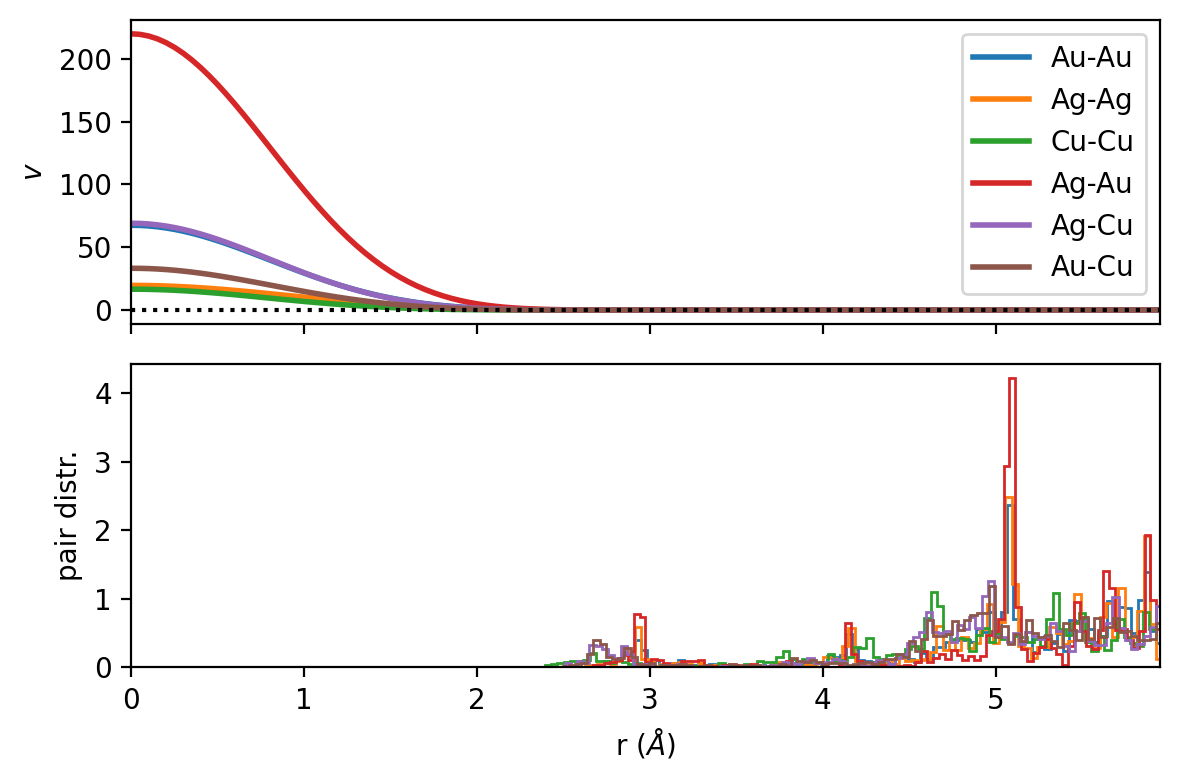

In [52]:
xmin = 0.0
xmax = rc
rij = np.arange(xmin, xmax, 0.05)
X = model.reconstruct_potential_twobody(
    rij, ["2b1", "2b2", "2b3", "2b4", "2b5", "2b6"]
)
PD = train.pair_distribution(rc, pbc_correction=True)

plot_twobody(
    X,
    PD,
    ["2b1", "2b2", "2b3", "2b4", "2b5", "2b6"],
    fname="reconstruction_2b_auagcu.png",
)

In [23]:
repulsive_test(model,["2b1", "2b2", "2b3", "2b4", "2b5", "2b6"])

58 3 1 9
58 12 1 9
58 21 1 10
58 31 1 9
58 40 1 9
58 49 1 9


False

# $R_{cut}$ Optimisation

At the moment fix $\alpha$ = $\beta$ = 11, cut off equal for all 2b potentials. Use Monte Carlo cross-validation with 10 models.

In [10]:
n_models = 10
alpha = 11
seeds = np.random.randint(0,100000,n_models)

In [7]:
#Max cut-off
rc = 10.0
train.update_rcut(rc)
test.update_rcut(rc)

In [12]:
rcuts = np.linspace(2.0,10.0,20)

mae = np.zeros((len(rcuts),n_models))
rmse = np.zeros((len(rcuts),n_models))
repulsive_check = []

for j in range(len(rcuts)):
    
    #rcuts
    rc = rcuts[j]
    print(rc)
    
    features = Features()
    #1 body
    features.add_feature(JL(lmax=5,nmax=5,rcut=rc,alpha=1.0,beta=1.0,gamma=1.0,nbody=1,type_groups=["Au", "Ag", "Cu"],name="1b"))
    #2 body
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Au"],name="2b1"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Ag"],name="2b2"))
    features.add_feature(JL(lmax=5,nmax=9,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Cu,Cu"],name="2b3"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Au"],name="2b4"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Cu"],name="2b5"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Cu"],name="2b6"))
    #Model
    model = LinearModel(features=features,alpha=0.0,fit_forces=False,coupling=1,n_workers=1)
    
    #Different model training
    repulsive_check.append([])
    
    for i in range(n_models):
        
        #Split training, CV sets.
        Tr, CV = split(train,0.8,0.2,seeds[i])
        #Fit
        model.fit(Tr)
        #Collect assessment info.
        mae[j,i] = model.get_mae(CV)['Energy']
        rmse[j,i] = model.get_rms(CV)['Energy']
        repulsive_check[-1].append(repulsive_test(model,["2b1", "2b2", "2b3", "2b4", "2b5", "2b6"]))

2.0
2.4210526315789473
2.8421052631578947
3.263157894736842
3.6842105263157894
4.105263157894736
4.526315789473684
4.947368421052632
5.368421052631579
5.789473684210526
6.2105263157894735
6.631578947368421
7.052631578947368
7.473684210526315
7.894736842105263
8.31578947368421
8.736842105263158
9.157894736842104
9.578947368421051
10.0


In [13]:
checker = []
for i in range(len(repulsive_check)):
    if False in repulsive_check[i]:
        checker.append(i)

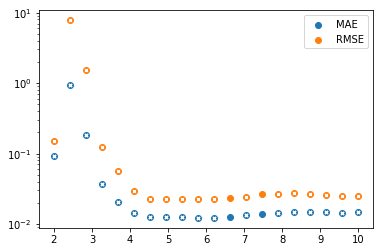

In [14]:
plt.figure(0)
plt.yscale('log')
plt.scatter(rcuts,np.mean(mae,axis=1),label='MAE')
plt.scatter(rcuts,np.mean(rmse,axis=1),label='RMSE')
for i in checker:
    plt.scatter(rcuts[i],np.mean(mae,axis=1)[i],marker='x',c='white',s=10)
    plt.scatter(rcuts[i],np.mean(rmse,axis=1)[i],marker='x',c='white',s=7)
plt.legend()
plt.show()

In [18]:
repulsive_check

[[False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, True, False, True, False, False, False],
 [False, False, False, False, False, False, True, True, False, False],
 [False, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False],
 [True, False, False, True, True, True, False, True, False, False],
 [True, False, True, True, False, True, False, True, True, False],
 [True, False, True, True, True, True, True, True, True, False],
 [True, True, True, True, True, True, True, True, True, True],
 [True, True, True, True, True, False, True, True, True, True],
 [True, True, True, True, True, True, True, True, True, True],
 [True, True, True, True, True,

In [62]:
n_models = 1
seeds = np.random.randint(0,100000,n_models)

#rcuts
rc = 4.00
print(rc)

d = {"2b1": [],"2b2": [], "2b3": [], "2b4": [], "2b5": [],"2b6": []}

r_extra = np.linspace(-1.0,2.0,20)

for j in r_extra:

    features = Features()
    #1 body
    features.add_feature(JL(lmax=5,nmax=5,rcut=rc,alpha=1.0,beta=1.0,gamma=1.0,nbody=1,type_groups=["Au", "Ag", "Cu"],name="1b"))
    #2 body
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Au"],name="2b1"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc + 1.0,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Ag"],name="2b2"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc - 0.5,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Cu,Cu"],name="2b3"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc + 1.0,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Au"],name="2b4"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc + j,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Cu"],name="2b5"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Cu"],name="2b6"))
    #Model
    model = LinearModel(features=features,alpha=0.0,fit_forces=False,coupling=1,n_workers=1)

    #Different model training
    for i in range(n_models):

        #Split training, CV sets.
        Tr, CV = split(train,0.8,0.2,seeds[i])
        #Fit
        model.fit(Tr)
        #Collect assessment info.
        #print(model.get_mae(CV)['Energy'])
        #print(model.get_rms(CV)['Energy'])
        print(repulsive_test(model,["2b1", "2b2", "2b3", "2b4", "2b5", "2b6"]))
        X = model.reconstruct_potential_twobody(
            np.array([0]), ["2b1", "2b2", "2b3", "2b4", "2b5", "2b6"]
        )
        
        for key in X:
            for b2 in X[key]:
                d[key].append(X[key][b2][1][0])

4.0
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


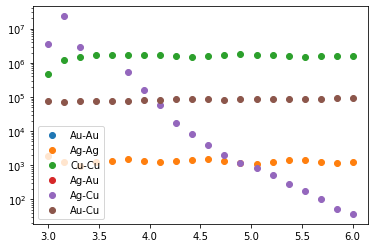

In [64]:
plt.figure(0)
for key in d:
    plt.scatter(rc+r_extra,d[key],label = list(X[key].keys())[0])
plt.yscale('log')
plt.legend()
plt.show()

In [45]:
X[key].keys()

dict_keys(['Au-Au'])

In [67]:
n_models = 20
seeds = np.random.randint(0,100000,n_models)
t_initial = time.time()

rcuts = np.linspace(2.0,10.0,20)

mae = np.zeros((len(rcuts),n_models))
rmse = np.zeros((len(rcuts),n_models))
repulsive_check = []
time_list = np.zeros(len(rcuts))
end_points = []

for j in range(len(rcuts)):
    
    #rcuts
    rc = rcuts[j]
    print(rc)
    t_loop = time.time()
    
    features = Features()
    #1 body
    features.add_feature(JL(lmax=5,nmax=5,rcut=rc,alpha=1.0,beta=1.0,gamma=1.0,nbody=1,type_groups=["Au", "Ag", "Cu"],name="1b"))
    #2 body
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Au"],name="2b1"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Ag"],name="2b2"))
    features.add_feature(JL(lmax=5,nmax=9,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Cu,Cu"],name="2b3"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Au"],name="2b4"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Cu"],name="2b5"))
    features.add_feature(JL(lmax=5,nmax=8,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Cu"],name="2b6"))
    #Model
    model = LinearModel(features=features,alpha=0.0,fit_forces=False,coupling=1,n_workers=1)
    
    #Different model training
    repulsive_check.append([])
    end_points.append([])
    
    for i in range(n_models):
        
        #Split training, CV sets.
        Tr, CV = split(train,0.8,0.2,seeds[i])
        #Fit
        model.fit(Tr)
        #Collect assessment info.
        mae[j,i] = model.get_mae(CV)['Energy']
        rmse[j,i] = model.get_rms(CV)['Energy']
        repulsive_check[-1].append(repulsive_test(model,["2b1", "2b2", "2b3", "2b4", "2b5", "2b6"]))
        X = model.reconstruct_potential_twobody(np.array([0]), ["2b1", "2b2", "2b3", "2b4", "2b5", "2b6"])
        end_points[-1].append(X)
    time_list[j] = time.time()-t_loop
    

print(time.time()-t_initial)

2.0
2.4210526315789473
2.8421052631578947
3.263157894736842
3.6842105263157894
4.105263157894736
4.526315789473684
4.947368421052632
5.368421052631579
5.789473684210526
6.2105263157894735
6.631578947368421
7.052631578947368
7.473684210526315
7.894736842105263
8.31578947368421
8.736842105263158
9.157894736842104
9.578947368421051
10.0
1628.1218721866608


In [71]:
time_ = [time_list[0]]
for i in range(1,len(time_list)):
    time_.append(time_list[i]-time_list[i-1])

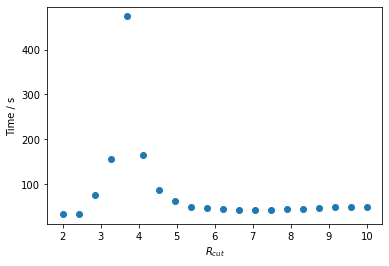

In [73]:
plt.figure(0)
plt.scatter(rcuts,time_)
plt.xlabel('$R_{cut}$')
plt.ylabel('Time / s')
plt.show()

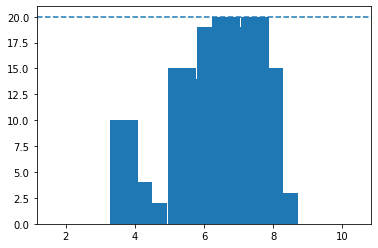

In [81]:
#Number repulsive against R_{cut}
N_True = []
for i in range(len(repulsive_check)):
    counter = 0
    for j in range(len(repulsive_check[j])):
        if repulsive_check[i][j]:
            counter+=1
    N_True.append(counter)

plt.figure(0)
plt.axhline(y=20,linestyle='--')
plt.bar(rcuts,N_True)
plt.show()

In [85]:
end_points[0]

[{'2b1': {'Au-Au': [array([0]), array([0.])]},
  '2b2': {'Ag-Ag': [array([0]), array([0.])]},
  '2b3': {'Cu-Cu': [array([0]), array([0.])]},
  '2b4': {'Ag-Au': [array([0]), array([0.])]},
  '2b5': {'Ag-Cu': [array([0]), array([0.])]},
  '2b6': {'Au-Cu': [array([0]), array([0.])]}},
 {'2b1': {'Au-Au': [array([0]), array([0.])]},
  '2b2': {'Ag-Ag': [array([0]), array([0.])]},
  '2b3': {'Cu-Cu': [array([0]), array([0.])]},
  '2b4': {'Ag-Au': [array([0]), array([0.])]},
  '2b5': {'Ag-Cu': [array([0]), array([0.])]},
  '2b6': {'Au-Cu': [array([0]), array([0.])]}},
 {'2b1': {'Au-Au': [array([0]), array([0.])]},
  '2b2': {'Ag-Ag': [array([0]), array([0.])]},
  '2b3': {'Cu-Cu': [array([0]), array([0.])]},
  '2b4': {'Ag-Au': [array([0]), array([0.])]},
  '2b5': {'Ag-Cu': [array([0]), array([0.])]},
  '2b6': {'Au-Cu': [array([0]), array([0.])]}},
 {'2b1': {'Au-Au': [array([0]), array([0.])]},
  '2b2': {'Ag-Ag': [array([0]), array([0.])]},
  '2b3': {'Cu-Cu': [array([0]), array([0.])]},
  '2b4': {

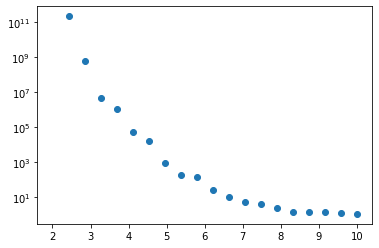

In [94]:
dist = []

for i in range(len(end_points)):
    dist_rc = []
    for j in range(len(end_points[i])):
        vals = []
        for key in end_points[i][j]:
            for b2 in end_points[i][j][key]:
                vals.append(end_points[i][j][key][b2][1][0])
        dist_rc.append(np.std(vals))
    dist.append(np.mean(dist_rc))

plt.figure(0)
plt.scatter(rcuts,dist)
plt.yscale('log')
plt.show()

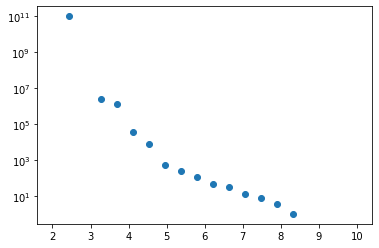

In [95]:
dist = []

for i in range(len(end_points)):
    dist_rc = []
    for j in range(len(end_points[i])):
        vals = []
        for key in end_points[i][j]:
            for b2 in end_points[i][j][key]:
                vals.append(end_points[i][j][key][b2][1][0])
        dist_rc.append(np.mean(vals))
    dist.append(np.mean(dist_rc))

plt.figure(0)
plt.scatter(rcuts,dist)
plt.yscale('log')
plt.show()

/tmp/ipykernel_7963/3887301852.py:10: RuntimeWarning: invalid value encountered in double_scalars
  dist_rc.append(np.std(vals)/np.mean(vals))


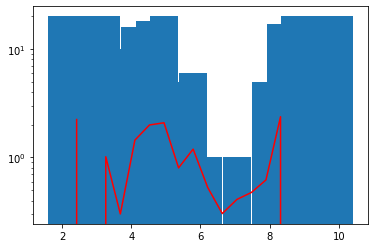

In [103]:
dist = []

for i in range(len(end_points)):
    dist_rc = []
    for j in range(len(end_points[i])):
        vals = []
        for key in end_points[i][j]:
            for b2 in end_points[i][j][key]:
                vals.append(end_points[i][j][key][b2][1][0])
        dist_rc.append(np.std(vals)/np.mean(vals))
    dist.append(np.mean(dist_rc))

plt.figure(0)
plt.plot(rcuts,dist,c='r')
plt.bar(rcuts,[20-i for i in N_True])
plt.yscale('log')
plt.show()

# $n_{max}$ and $R_{cut}$

In [107]:
n_models = 10
alpha = 11
seeds = np.random.randint(0,100000,n_models)

In [108]:
#Max cut-off
rc = 10.0
train.update_rcut(rc)
test.update_rcut(rc)

In [ ]:
rcuts = [6.7]
nmaxs = [1,2,3,4,5,6,7,8,9,10,15,20,25,30]

mae = np.zeros((len(nmaxs),n_models))
rmse = np.zeros((len(nmaxs),n_models))
repulsive_check = []

for k in range(len(rcuts)):
    for j in range(len(nmaxs)):
        #rcuts
        rc = rcuts[k]
        print(rc)
        
        #nmax
        nmax = nmaxs[j]

        features = Features()
        #1 body
        features.add_feature(JL(lmax=5,nmax=5,rcut=rc,alpha=1.0,beta=1.0,gamma=1.0,nbody=1,type_groups=["Au", "Ag", "Cu"],name="1b"))
        #2 body
        features.add_feature(JL(lmax=5,nmax=nmax,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Au"],name="2b1"))
        features.add_feature(JL(lmax=5,nmax=nmax,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Ag"],name="2b2"))
        features.add_feature(JL(lmax=5,nmax=nmax,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Cu,Cu"],name="2b3"))
        features.add_feature(JL(lmax=5,nmax=nmax,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Au"],name="2b4"))
        features.add_feature(JL(lmax=5,nmax=nmax,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Ag,Cu"],name="2b5"))
        features.add_feature(JL(lmax=5,nmax=nmax,rcut=rc,alpha=alpha,beta=alpha,gamma=1.0,nbody=2,type_groups=["Au,Cu"],name="2b6"))
        #Model
        model = LinearModel(features=features,alpha=0.0,fit_forces=False,coupling=1,n_workers=1)

        #Different model training
        repulsive_check.append([])

        for i in range(n_models):

            #Split training, CV sets.
            Tr, CV = split(train,0.8,0.2,seeds[i])
            #Fit
            model.fit(Tr)
            #Collect assessment info.
            mae[j,i] = model.get_mae(CV)['Energy']
            rmse[j,i] = model.get_rms(CV)['Energy']
            repulsive_check[-1].append(repulsive_test(model,["2b1", "2b2", "2b3", "2b4", "2b5", "2b6"]))

6.7
6.7
6.7
6.7
6.7
6.7


In [114]:
N_True = []
for i in range(len(repulsive_check)):
    counter = 0
    for j in range(len(repulsive_check[j])):
        if repulsive_check[i][j]:
            counter+=1
    N_True.append(counter)

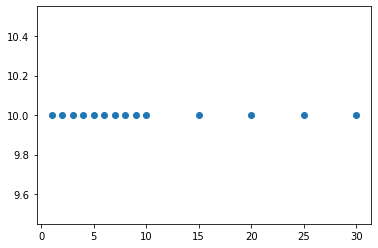

In [115]:
plt.figure(0)
plt.scatter(nmaxs,N_True)
plt.show()

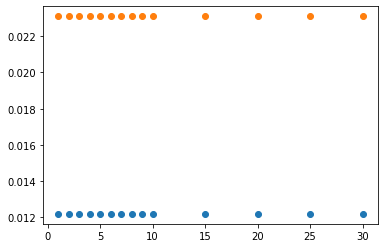

In [116]:
plt.figure(0)
plt.scatter(nmaxs,np.mean(mae,axis=1))
plt.scatter(nmaxs,np.mean(rmse,axis=1))
plt.show()